Tested the effect of the observational noise on learned assignment and embeddings

In [1]:
%load_ext autoreload
%autoreload 2

In [102]:
import numpy as np
import pandas as pd
import tensorflow as tf
import gpflow

from utils import *
from plot import *

In [14]:
np.random.seed(1)

num_data = 200
dim = 5

xmin = -5
xmax = 5
break_pt = xmin + (xmax - xmin) * 0.5
k1 = 0.0
k21 = 0.5
k22 = -0.5
c1 = 0
sigma = 0.1
noise = 0.01

x = np.linspace(xmin, xmax, int(num_data/2), dtype=default_float())
X = branch_simulation(x, break_pt, k1, k21, k22, c1, sigma)
labels = np.repeat([0, 1], int(num_data)/2)
labels_dummy = pd.get_dummies(labels).values

fx, gx = bgp_kernel(X, break_pt, dim)

break_num = x[x < break_pt].size
halfpt = int(num_data / 2)
tmp1 = fx[:break_num]
tmp2 = fx[break_num:halfpt]
tmp3 = gx[-(halfpt-break_num):]
Y = np.concatenate([tmp1, tmp2, tmp1, tmp3], axis=0)

In [15]:
np.random.seed(3)
M = 30
X_pca = PCA(n_components=2).fit_transform(Y)
Z = np.random.permutation(X)[:M]

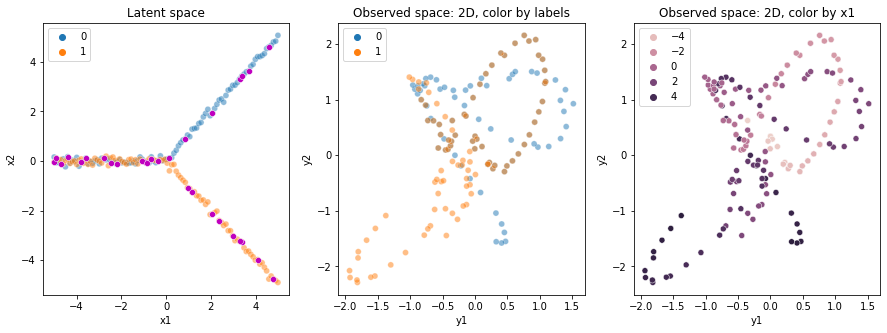

In [16]:
# without noise
plot_Y(Y, X, labels, Z)

Text(0, 0.5, 'y1')

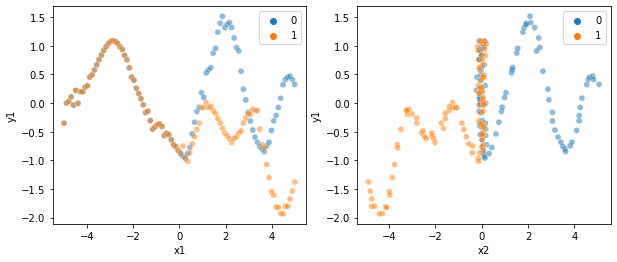

In [18]:
x1 = X[:, 0]
x2 = X[:, 1]
y1 = Y[:, 0]
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
sns.scatterplot(x=x1, y=y1, hue=labels, alpha=0.5, ax=axs[0])
axs[0].set_xlabel('x1')
axs[0].set_ylabel('y1')
sns.scatterplot(x=x2, y=y1, hue=labels, alpha=0.5, ax=axs[1])
axs[1].set_xlabel('x2')
axs[1].set_ylabel('y1')

Text(0, 0.5, 'PC 2')

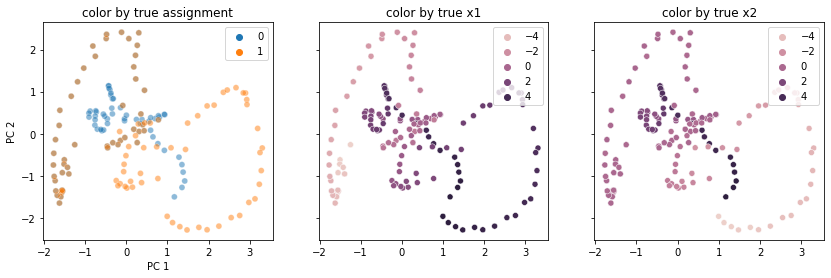

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4), sharex=True, sharey=True)
xmean = PCA(n_components=2).fit_transform(Y)
x1 = xmean[:, 0]
x2 = xmean[:, 1]
sns.scatterplot(x=x1, y=x2, hue=labels, ax=axs[0], alpha=0.5)
axs[0].set_title('color by true assignment')
sns.scatterplot(x=x1, y=x2, hue=X[:, 0], ax=axs[1])
axs[1].set_title('color by true x1')
sns.scatterplot(x=x1, y=x2, hue=X[:, 1], ax=axs[2])
axs[2].set_title('color by true x2')
axs[0].set_xlabel('PC 1')
axs[0].set_ylabel('PC 2')

In [37]:
def plot_embedding(m):
    fig, axs = plt.subplots(1, 4, figsize=(18, 4), sharex=True, sharey=True)
    x1 = m.Xs_mean.numpy().flatten()
    x2 = m.Xp_mean.numpy().flatten()
    sns.scatterplot(x=x1, y=x2, hue=labels, ax=axs[0], alpha=0.5)
    axs[0].set_title('color by true assignment')
    sns.scatterplot(x=x1, y=x2, hue=m.pi.numpy()[:, 0], ax=axs[1])
    axs[1].set_title('color by learned assignment')
    sns.scatterplot(x=x1, y=x2, hue=X[:, 0], ax=axs[2])
    axs[2].set_title('color by true x1')
    sns.scatterplot(x=x1, y=x2, hue=X[:, 1], ax=axs[3])
    axs[3].set_title('color by true x2')
    axs[0].set_xlabel('shared')
    axs[0].set_ylabel('private')

In [21]:
# fix X true, learn variance
m1 = init_split_gplvm(
    Y=Y,
    split_space=True,
    Qp=1,
    K=2,
    Zp=Z[:, 1][:, np.newaxis],
    Qs=1,
    Zs=Z[:, 0][:, np.newaxis],
    pi_init=tf.constant(np.random.dirichlet(alpha=[2, 2], size=(X.shape[0])), dtype=default_float()),
    Xp_mean_init=X[:, 1][:, np.newaxis],
    Xp_var_init=np.full((num_data, 1), 1e-4),
    Xs_mean_init=X[:, 0][:, np.newaxis],
    Xs_var_init=np.full((num_data, 1), 1e-4)
)
set_trainable(m1.Xp_mean, False)
set_trainable(m1.Xp_var, False)
set_trainable(m1.Xs_mean, False)
set_trainable(m1.Xs_var, False)

In [22]:
# learn X, init PC 1, learn variance,
m2 = init_split_gplvm(
    Y=Y,
    split_space=True,
    Qp=1,
    K=2,
    Zp=Z[:, 1][:, np.newaxis],
    Qs=1,
    Zs=Z[:, 0][:, np.newaxis],
    pi_init=tf.constant(np.random.dirichlet(alpha=[2, 2], size=(X.shape[0])), dtype=default_float())
)

In [45]:
# fix X true, fix variance=0.1
m3 = init_split_gplvm(
    Y=Y,
    split_space=True,
    Qp=1,
    K=2,
    Zp=Z[:, 1][:, np.newaxis],
    Qs=1,
    Zs=Z[:, 0][:, np.newaxis],
    pi_init=tf.constant(np.random.dirichlet(alpha=[2, 2], size=(X.shape[0])), dtype=default_float()),
    Xp_mean_init=X[:, 1][:, np.newaxis],
    Xp_var_init=np.full((num_data, 1), 1e-4),
    Xs_mean_init=X[:, 0][:, np.newaxis],
    Xs_var_init=np.full((num_data, 1), 1e-4)
)
m3.likelihood.variance.assign(0.1)
set_trainable(m3.Xp_mean, False)
set_trainable(m3.Xp_var, False)
set_trainable(m3.Xs_mean, False)
set_trainable(m3.Xs_var, False)
set_trainable(m3.likelihood.variance, False)

In [59]:
# learn X, init PC 1, fix variance=0.1
m4 = init_split_gplvm(
    Y=Y,
    split_space=True,
    Qp=1,
    K=2,
    Zp=Z[:, 1][:, np.newaxis],
    Qs=1,
    Zs=Z[:, 0][:, np.newaxis],
    pi_init=tf.constant(np.random.dirichlet(alpha=[2, 2], size=(X.shape[0])), dtype=default_float())
)
m4.likelihood.variance.assign(0.1)
set_trainable(m4.likelihood.variance, False)

In [60]:
m = m4
set_trainable(m.kernel_K[0].variance, False)
set_trainable(m.kernel_K[1].variance, False)
set_trainable(m.kernel_s.variance, False)
set_trainable(m.kernel_K[0].lengthscales, False)
set_trainable(m.kernel_K[1].lengthscales, False)
set_trainable(m.kernel_s.lengthscales, False)
set_trainable(m.Zp, False)
set_trainable(m.Zs, False)

In [27]:
%%time
elbo1 = train_natgrad_adam(m1, 2000, 100)

initial elbo -6653734.5025
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
iteration 100 elbo -3769.0937, took 0.0853s
iteration 200 elbo -3419.1410, took 0.0903s
iteration 300 elbo -3106.9229, took 0.1151s
iteration 400 elbo -2890.1398, took 0.0855s
iteration 500 elbo -2715.5447, took 0.1106s
iteration 600 elbo -2598.8386, took 0.0886s
iteration 700 elbo -2538.4438, took 0.1167s
iteration 800 elbo -2516.8288, took 0.0859s
iteration 900 elbo -2507.2931, took 0.0829s
iteration 1000 elbo -2503.6584, took 0.0847s
iteration 1100 elbo -2501.9122, took 0.1431s
iteration 1200 elbo -2500.8827, took 0.0894s
iteration 1300 elbo -2500.2030, took 0.0863s
iteration 1400 elbo -2499.7215, took 0.1093s
iteration 1500 elbo -2499.3636, took 0.0845s
iteration 1600 elbo -2499.0881, took 0.0866s
iteration 1700 elbo -2498.8701, took 0.0867s
iteration 1800 elbo -2498.6939, took 0.1219s
iteration 1900 elbo -2498.5489, took 0.0856s
iteration

In [28]:
%%time
elbo2 = train_natgrad_adam(m2, 2000, 100)

initial elbo -7457350.7536
iteration 100 elbo -1486.7820, took 0.1342s
iteration 200 elbo -1433.7181, took 0.1528s
iteration 300 elbo -1369.5712, took 0.1302s
iteration 400 elbo -1307.0234, took 0.1349s
iteration 500 elbo -1265.2640, took 0.1329s
iteration 600 elbo -1242.8742, took 0.1285s
iteration 700 elbo -1224.6783, took 0.1266s
iteration 800 elbo -1213.4767, took 0.1252s
iteration 900 elbo -1208.1195, took 0.1642s
iteration 1000 elbo -1205.5014, took 0.1323s
iteration 1100 elbo -1204.0594, took 0.1258s
iteration 1200 elbo -1203.1672, took 0.1280s
iteration 1300 elbo -1202.5573, took 0.1287s
iteration 1400 elbo -1202.0976, took 0.1320s
iteration 1500 elbo -1201.6791, took 0.1303s
iteration 1600 elbo -1201.0043, took 0.1460s
iteration 1700 elbo -1199.1979, took 0.1335s
iteration 1800 elbo -1198.3114, took 0.1416s
iteration 1900 elbo -1198.0640, took 0.1468s
iteration 2000 elbo -1197.8611, took 0.1498s
CPU times: user 9min 55s, sys: 3min 55s, total: 13min 51s
Wall time: 4min 57s


In [48]:
%%time
elbo3 = train_natgrad_adam(m3, 2000, 100)

initial elbo -7054069.2437
iteration 100 elbo -3206.0094, took 0.0892s
iteration 200 elbo -3201.7933, took 0.0928s
iteration 300 elbo -3199.9063, took 0.1322s
iteration 400 elbo -3197.2736, took 0.1291s
iteration 500 elbo -3191.2979, took 0.1107s
iteration 600 elbo -3178.6469, took 0.0874s
iteration 700 elbo -3172.5107, took 0.0854s
iteration 800 elbo -3167.2778, took 0.0885s
iteration 900 elbo -3157.9263, took 0.0941s
iteration 1000 elbo -3148.8788, took 0.0919s
iteration 1100 elbo -3141.6275, took 0.0906s
iteration 1200 elbo -3139.0503, took 0.0897s
iteration 1300 elbo -3136.6968, took 0.0891s
iteration 1400 elbo -3135.5557, took 0.0891s
iteration 1500 elbo -3135.1125, took 0.1058s
iteration 1600 elbo -3134.8673, took 0.0883s
iteration 1700 elbo -3134.7043, took 0.0924s
iteration 1800 elbo -3134.5860, took 0.0855s
iteration 1900 elbo -3134.4957, took 0.0950s
iteration 2000 elbo -3134.4244, took 0.1076s
CPU times: user 6min 47s, sys: 2min 30s, total: 9min 18s
Wall time: 3min 26s


In [67]:
%%time
elbo4 = train_natgrad_adam(m4, 2000, 100)

initial elbo -15113547.9005
iteration 100 elbo -2577.7164, took 0.1815s
iteration 200 elbo -1858.8299, took 0.2593s
iteration 300 elbo -1540.9659, took 0.1378s
iteration 400 elbo -1360.9598, took 0.1494s
iteration 500 elbo -1279.7418, took 0.1525s
iteration 600 elbo -1242.9865, took 0.1786s
iteration 700 elbo -1224.8851, took 0.1288s
iteration 800 elbo -1215.2469, took 0.1537s
iteration 900 elbo -1209.6038, took 0.1376s
iteration 1000 elbo -1205.7890, took 0.1287s
iteration 1100 elbo -1202.5540, took 0.1325s
iteration 1200 elbo -1199.2638, took 0.1527s
iteration 1300 elbo -1196.0904, took 0.1552s
iteration 1400 elbo -1193.2665, took 0.1289s
iteration 1500 elbo -1190.5752, took 0.1295s
iteration 1600 elbo -1187.5675, took 0.1282s
iteration 1700 elbo -1181.4367, took 0.1435s
iteration 1800 elbo -1174.5841, took 0.1298s
iteration 1900 elbo -1172.2871, took 0.1718s
iteration 2000 elbo -1171.0856, took 0.1592s
CPU times: user 9min 57s, sys: 4min 2s, total: 13min 59s
Wall time: 4min 56s


The assignments in m3 makes the most sense, but it has the lowest ELBO. We definitely need some sort of constraint to combat the overfitting in other cases. 

In [95]:
names = [
    'fixed X, learn variance',
    'learn X, learn variance',
    'fixed X, fixed variance=0.1',
    'learn X, fixed variance=0.1'
]

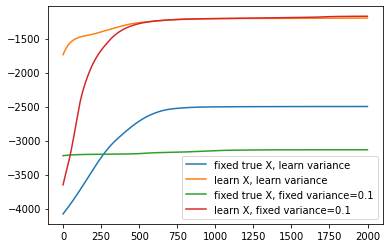

In [68]:
plt.plot(elbo1, label='fixed true X, learn variance')
plt.plot(elbo2, label='learn X, learn variance')
plt.plot(elbo3, label='fixed true X, fixed variance=0.1')
plt.plot(elbo4, label='learn X, fixed variance=0.1')

plt.legend()

In [30]:
m1

<split_gplvm.SplitGPLVM object at 0x14c836470>
╒═════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════════╤═════════╤══════════════════════════════════════════════════════╕
│ name                                │ class     │ transform        │ prior   │ trainable   │ shape       │ dtype   │ value                                                │
╞═════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════════╪═════════╪══════════════════════════════════════════════════════╡
│ SplitGPLVM.likelihood.variance      │ Parameter │ Softplus + Shift │         │ True        │ ()          │ float64 │ 0.005639354299738185                                 │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────────────────┤
│ SplitGPLVM.kernel_K[0].variance     │ Parameter │ Softplus         │         │ False       │ ()          │ float64 │ 1.0                                                  │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────────────────┤
│ SplitGPLVM.kernel_K[0].lengthscales │ Parameter │ Softplus         │         │ False       │ (1,)        │ float64 │ [1.]                                                 │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────────────────┤
│ SplitGPLVM.kernel_K[1].variance     │ Parameter │ Softplus         │         │ False       │ ()          │ float64 │ 1.0                                                  │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────────────────┤
│ SplitGPLVM.kernel_K[1].lengthscales │ Parameter │ Softplus         │         │ False       │ (1,)        │ float64 │ [1.]                                                 │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────────────────┤
│ SplitGPLVM.Xp_mean                  │ Parameter │                  │         │ False       │ (200, 1)    │ float64 │ [[1.62434536e-01...                                  │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────────────────┤
│ SplitGPLVM.Xp_var                   │ Parameter │ Softplus         │         │ False       │ (200, 1)    │ float64 │ [[1.e-04...                                          │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────────────────┤
│ SplitGPLVM.pi                       │ Parameter │ SoftmaxCentered  │         │ True        │ (200, 2)    │ float64 │ [[3.58422552e-04, 9.99641577e-01...                  │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────────────────┤
│ SplitGPLVM.Zp.Z                     │ Parameter │                  │         │ False       │ (30, 1)     │ float64 │ [[-1.91835552e-02...                                 │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────────────────┤
│ SplitGPLVM.q_mu[0]                  │ Parameter │                  │         │ False       │ (30, 5)     │ float64 │ [[-0.32935464, 0.25547334, -0.55643902...            │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼───────

In [31]:
m2

<split_gplvm.SplitGPLVM object at 0x14bdb7198>
╒═════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════════╤═════════╤══════════════════════════════════════════════════════╕
│ name                                │ class     │ transform        │ prior   │ trainable   │ shape       │ dtype   │ value                                                │
╞═════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════════╪═════════╪══════════════════════════════════════════════════════╡
│ SplitGPLVM.likelihood.variance      │ Parameter │ Softplus + Shift │         │ True        │ ()          │ float64 │ 0.07404800533622742                                  │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────────────────┤
│ SplitGPLVM.kernel_K[0].variance     │ Parameter │ Softplus         │         │ False       │ ()          │ float64 │ 1.0                                                  │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────────────────┤
│ SplitGPLVM.kernel_K[0].lengthscales │ Parameter │ Softplus         │         │ False       │ (1,)        │ float64 │ [1.]                                                 │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────────────────┤
│ SplitGPLVM.kernel_K[1].variance     │ Parameter │ Softplus         │         │ False       │ ()          │ float64 │ 1.0                                                  │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────────────────┤
│ SplitGPLVM.kernel_K[1].lengthscales │ Parameter │ Softplus         │         │ False       │ (1,)        │ float64 │ [1.]                                                 │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────────────────┤
│ SplitGPLVM.Xp_mean                  │ Parameter │                  │         │ True        │ (200, 1)    │ float64 │ [[0.49167649...                                      │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────────────────┤
│ SplitGPLVM.Xp_var                   │ Parameter │ Softplus         │         │ True        │ (200, 1)    │ float64 │ [[0.0303286...                                       │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────────────────┤
│ SplitGPLVM.pi                       │ Parameter │ SoftmaxCentered  │         │ True        │ (200, 2)    │ float64 │ [[3.27228425e-05, 9.99967277e-01...                  │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────────────────┤
│ SplitGPLVM.Zp.Z                     │ Parameter │                  │         │ False       │ (30, 1)     │ float64 │ [[-1.91835552e-02...                                 │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────────────────┤
│ SplitGPLVM.q_mu[0]                  │ Parameter │                  │         │ False       │ (30, 5)     │ float64 │ [[9.84181087e-01, 1.36797626e+00, -2.86523299e-01... │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼───────

In [51]:
m3

<split_gplvm.SplitGPLVM object at 0x16a6bf8d0>
╒═════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════════╤═════════╤═══════════════════════════════════════════╕
│ name                                │ class     │ transform        │ prior   │ trainable   │ shape       │ dtype   │ value                                     │
╞═════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════════╪═════════╪═══════════════════════════════════════════╡
│ SplitGPLVM.likelihood.variance      │ Parameter │ Softplus + Shift │         │ False       │ ()          │ float64 │ 0.09999999999999999                       │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼───────────────────────────────────────────┤
│ SplitGPLVM.kernel_K[0].variance     │ Parameter │ Softplus         │         │ False       │ ()          │ float64 │ 1.0                                       │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼───────────────────────────────────────────┤
│ SplitGPLVM.kernel_K[0].lengthscales │ Parameter │ Softplus         │         │ False       │ (1,)        │ float64 │ [1.]                                      │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼───────────────────────────────────────────┤
│ SplitGPLVM.kernel_K[1].variance     │ Parameter │ Softplus         │         │ False       │ ()          │ float64 │ 1.0                                       │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼───────────────────────────────────────────┤
│ SplitGPLVM.kernel_K[1].lengthscales │ Parameter │ Softplus         │         │ False       │ (1,)        │ float64 │ [1.]                                      │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼───────────────────────────────────────────┤
│ SplitGPLVM.Xp_mean                  │ Parameter │                  │         │ False       │ (200, 1)    │ float64 │ [[1.62434536e-01...                       │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼───────────────────────────────────────────┤
│ SplitGPLVM.Xp_var                   │ Parameter │ Softplus         │         │ False       │ (200, 1)    │ float64 │ [[1.e-04...                               │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼───────────────────────────────────────────┤
│ SplitGPLVM.pi                       │ Parameter │ SoftmaxCentered  │         │ True        │ (200, 2)    │ float64 │ [[1.59059057e-01, 8.40940943e-01...       │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼───────────────────────────────────────────┤
│ SplitGPLVM.Zp.Z                     │ Parameter │                  │         │ False       │ (30, 1)     │ float64 │ [[-1.91835552e-02...                      │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼───────────────────────────────────────────┤
│ SplitGPLVM.q_mu[0]                  │ Parameter │                  │         │ False       │ (30, 5)     │ float64 │ [[-0.41569732, 0.16604734, -0.46386306... │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼───────────────────────────────────────────┤
│ SplitGPLVM.q_mu[1]                  │ Parameter │                  │         │ False       │ (30, 5)     │ float64 │ [[-0.38963817, 0.27698898, -0.50489541... │
├─────────────────────────────────────┼──

In [69]:
m4

<split_gplvm.SplitGPLVM object at 0x1765be9b0>
╒═════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════════╤═════════╤═══════════════════════════════════════════════════════╕
│ name                                │ class     │ transform        │ prior   │ trainable   │ shape       │ dtype   │ value                                                 │
╞═════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════════╪═════════╪═══════════════════════════════════════════════════════╡
│ SplitGPLVM.likelihood.variance      │ Parameter │ Softplus + Shift │         │ False       │ ()          │ float64 │ 0.09999999999999999                                   │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼───────────────────────────────────────────────────────┤
│ SplitGPLVM.kernel_K[0].variance     │ Parameter │ Softplus         │         │ False       │ ()          │ float64 │ 1.0                                                   │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼───────────────────────────────────────────────────────┤
│ SplitGPLVM.kernel_K[0].lengthscales │ Parameter │ Softplus         │         │ False       │ (1,)        │ float64 │ [1.]                                                  │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼───────────────────────────────────────────────────────┤
│ SplitGPLVM.kernel_K[1].variance     │ Parameter │ Softplus         │         │ False       │ ()          │ float64 │ 1.0                                                   │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼───────────────────────────────────────────────────────┤
│ SplitGPLVM.kernel_K[1].lengthscales │ Parameter │ Softplus         │         │ False       │ (1,)        │ float64 │ [1.]                                                  │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼───────────────────────────────────────────────────────┤
│ SplitGPLVM.Xp_mean                  │ Parameter │                  │         │ True        │ (200, 1)    │ float64 │ [[0.2415721...                                        │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼───────────────────────────────────────────────────────┤
│ SplitGPLVM.Xp_var                   │ Parameter │ Softplus         │         │ True        │ (200, 1)    │ float64 │ [[0.03045204...                                       │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼───────────────────────────────────────────────────────┤
│ SplitGPLVM.pi                       │ Parameter │ SoftmaxCentered  │         │ True        │ (200, 2)    │ float64 │ [[9.98772073e-01, 1.22792681e-03...                   │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼───────────────────────────────────────────────────────┤
│ SplitGPLVM.Zp.Z                     │ Parameter │                  │         │ False       │ (30, 1)     │ float64 │ [[-1.91835552e-02...                                  │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼───────────────────────────────────────────────────────┤
│ SplitGPLVM.q_mu[0]                  │ Parameter │                  │         │ False       │ (30, 5)     │ float64 │ [[0.22862353, 0.69016084, -1.02565354...              │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────

In [65]:
def plot_assignment_true_x1(m, x1, ax):
    assignment = m.pi.numpy()[:, 0]
    ax.scatter(x1, assignment, alpha=0.5)

Text(0, 0.5, 'assignment probability for GP 0')

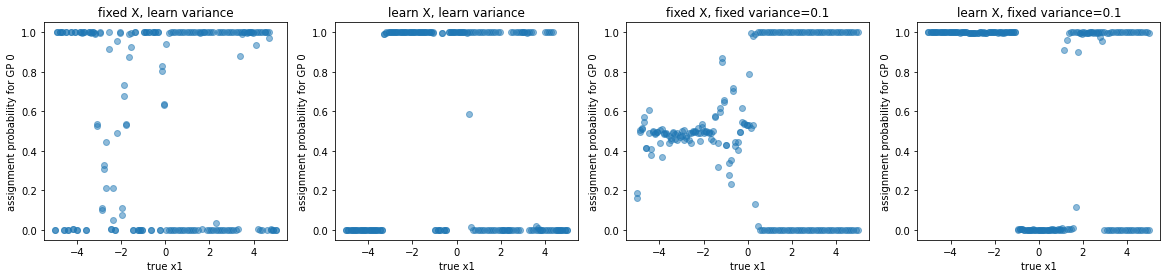

In [70]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))
plot_assignment_true_x1(m1, X[:, 0], axs[0])
axs[0].set_title('fixed X, learn variance')
axs[0].set_xlabel('true x1')
axs[0].set_ylabel('assignment probability for GP 0')

plot_assignment_true_x1(m2, X[:, 0], axs[1])
axs[1].set_title('learn X, learn variance')
axs[1].set_xlabel('true x1')
axs[1].set_ylabel('assignment probability for GP 0')

plot_assignment_true_x1(m3, X[:, 0], axs[2])
axs[2].set_title('fixed X, fixed variance=0.1')
axs[2].set_xlabel('true x1')
axs[2].set_ylabel('assignment probability for GP 0')

plot_assignment_true_x1(m4, X[:, 0], axs[3])
axs[3].set_title('learn X, fixed variance=0.1')
axs[3].set_xlabel('true x1')
axs[3].set_ylabel('assignment probability for GP 0')

Text(0, 0.5, 'true x2')

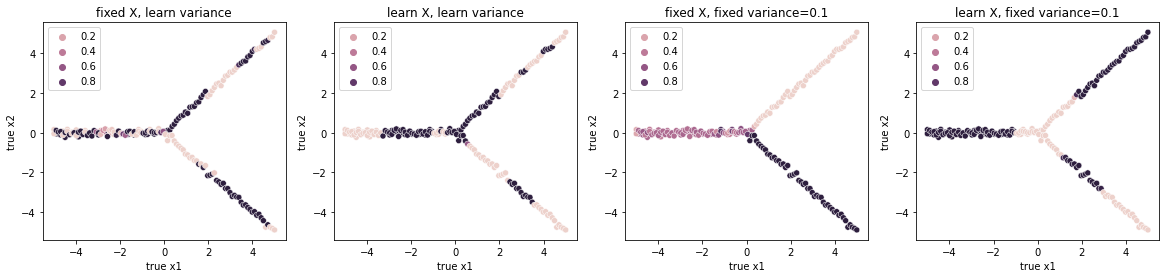

In [71]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))
plot_assignment(m1, X, axs[0])
axs[0].set_title('fixed X, learn variance')
axs[0].set_xlabel('true x1')
axs[0].set_ylabel('true x2')

plot_assignment(m2, X, axs[1])
axs[1].set_title('learn X, learn variance')
axs[1].set_xlabel('true x1')
axs[1].set_ylabel('true x2')

plot_assignment(m3, X, axs[2])
axs[2].set_title('fixed X, fixed variance=0.1')
axs[2].set_xlabel('true x1')
axs[2].set_ylabel('true x2')

plot_assignment(m4, X, axs[3])
axs[3].set_title('learn X, fixed variance=0.1')
axs[3].set_xlabel('true x1')
axs[3].set_ylabel('true x2')

In [33]:
predm1, predKm1 = get_pred_Y(m1, by_K=True)

Text(0.5, 1.0, 'true observations by true labels')

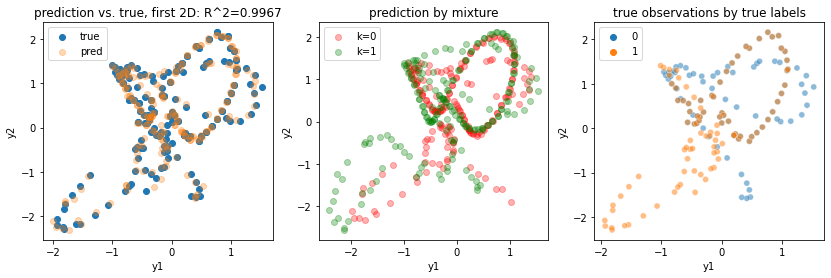

In [34]:
pred = predm1
predK = predKm1

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
plot_pred_vs_true(Y, pred, axs[0])
plot_pred_by_K(predK, axs[1])
sns.scatterplot(x=Y[:, 0], y=Y[:, 1], hue=labels, alpha=0.5, ax=axs[2])
axs[2].set_xlabel('y1')
axs[2].set_ylabel('y2')
axs[2].set_title('true observations by true labels')

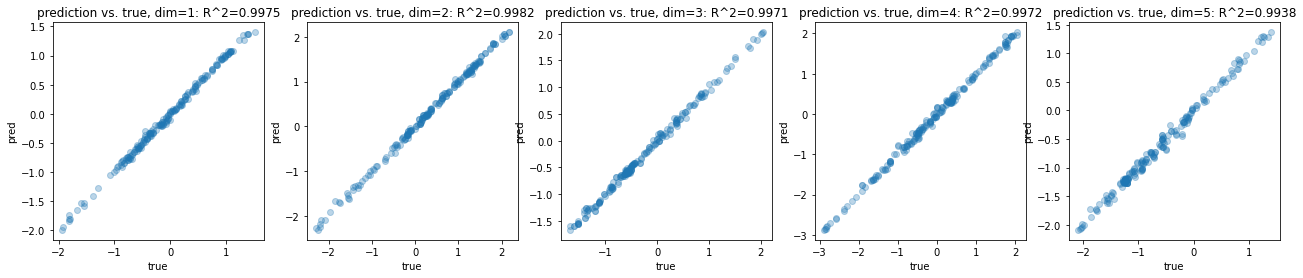

In [35]:
fig, axs = plt.subplots(1, 5, figsize=(22, 4))
for i in range(dim):
    plot_pred_true_1d(Y, pred, i+1, axs[i])

In [75]:
predm3, predKm3 = get_pred_Y(m3, by_K=True)

Text(0, 0.5, 'y2')

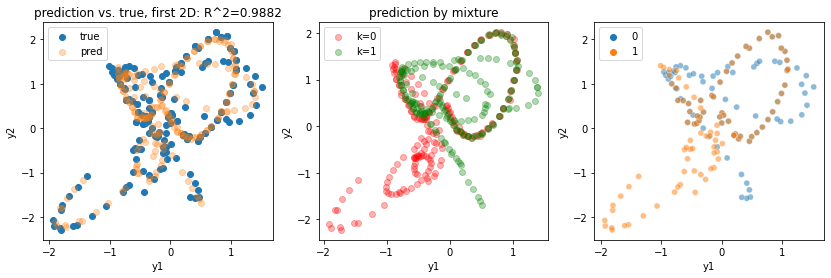

In [76]:
pred = predm3
predK = predKm3

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
plot_pred_vs_true(Y, pred, axs[0])
plot_pred_by_K(predK, axs[1])
sns.scatterplot(x=Y[:, 0], y=Y[:, 1], hue=labels, alpha=0.5, ax=axs[2])
axs[2].set_xlabel('y1')
axs[2].set_ylabel('y2')

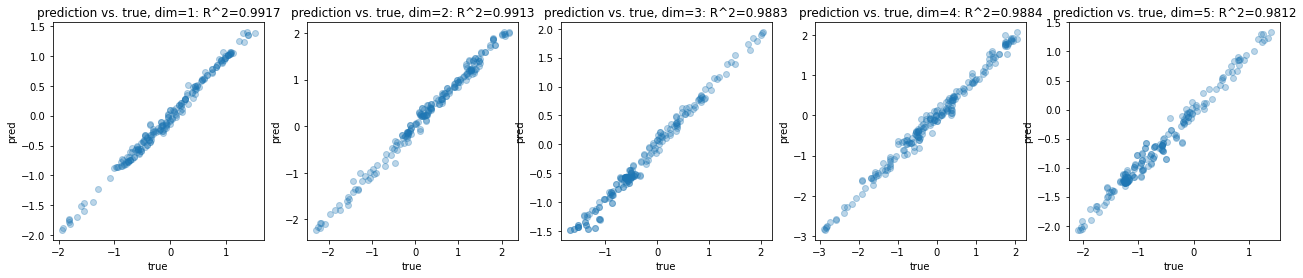

In [77]:
fig, axs = plt.subplots(1, 5, figsize=(22, 4))
for i in range(dim):
    plot_pred_true_1d(Y, pred, i+1, axs[i])

Learn X

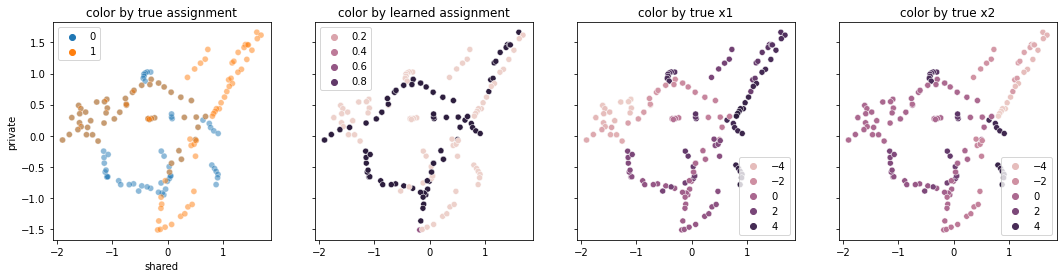

In [38]:
plot_embedding(m2)

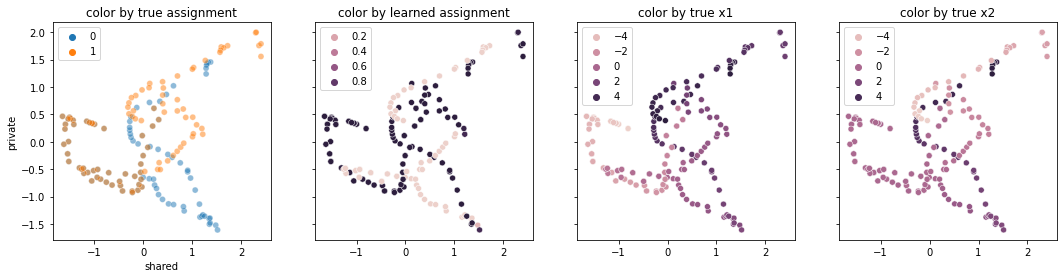

In [78]:
plot_embedding(m4)

In [39]:
predm2, predKm2 = get_pred_Y(m2, by_K=True)

[autoreload of utils failed: Traceback (most recent call last):
  File "/Users/jxiong/Documents/Projects/ipsc_gplvm/env/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/jxiong/Documents/Projects/ipsc_gplvm/env/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/jxiong/Documents/Projects/ipsc_gplvm/utils.py", line 17, in <modul

Text(0.5, 1.0, 'true observations by true labels')

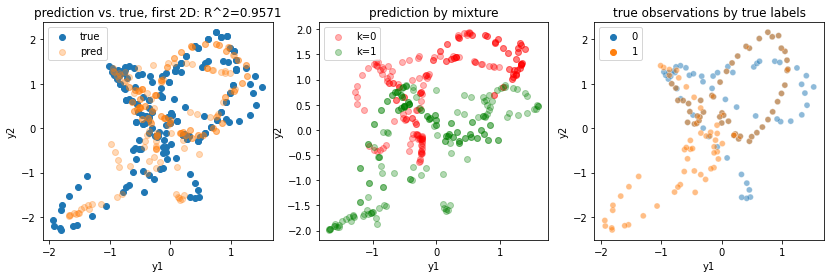

In [107]:
pred = predm2
predK = predKm2

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
plot_pred_vs_true(Y, pred, axs[0])
plot_pred_by_K(predK, axs[1])
sns.scatterplot(x=Y[:, 0], y=Y[:, 1], hue=labels, alpha=0.5, ax=axs[2])
axs[2].set_xlabel('y1')
axs[2].set_ylabel('y2')
axs[2].set_title('true observations by true labels')

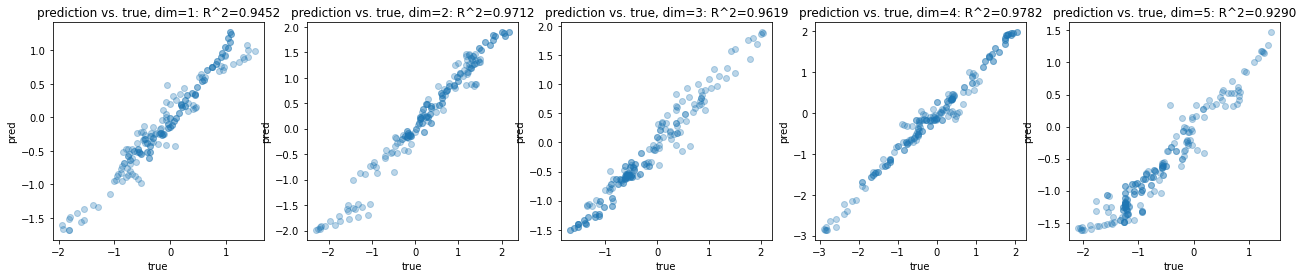

In [41]:
fig, axs = plt.subplots(1, 5, figsize=(22, 4))
for i in range(dim):
    plot_pred_true_1d(Y, pred, i+1, axs[i])

In [72]:
predm4, predKm4 = get_pred_Y(m4, by_K=True)

Text(0, 0.5, 'y2')

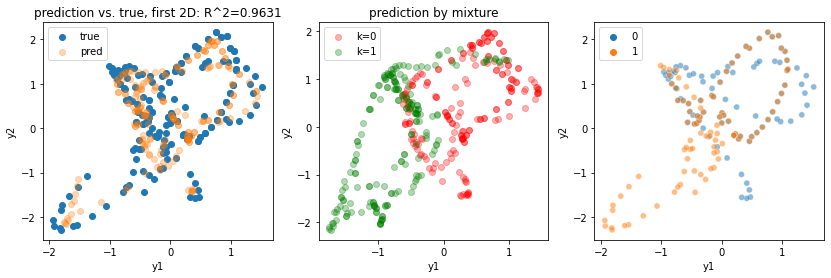

In [73]:
pred = predm4
predK = predKm4

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
plot_pred_vs_true(Y, pred, axs[0])
plot_pred_by_K(predK, axs[1])
sns.scatterplot(x=Y[:, 0], y=Y[:, 1], hue=labels, alpha=0.5, ax=axs[2])
axs[2].set_xlabel('y1')
axs[2].set_ylabel('y2')

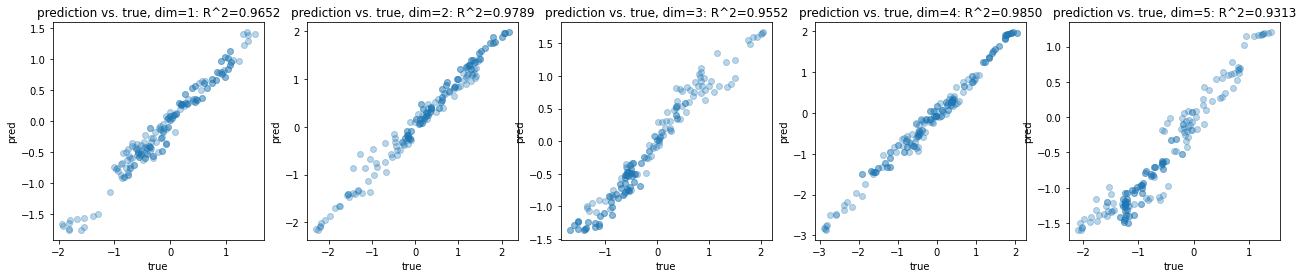

In [74]:
fig, axs = plt.subplots(1, 5, figsize=(22, 4))
for i in range(dim):
    plot_pred_true_1d(Y, pred, i+1, axs[i])

m2 and m4 has worst predictions but higher ELBO. Because the KL(X) for the true embedding is much greater than the learned embeddings, i.e. our prior p(X) is not encouraging the model to learn the true embedding

Text(0.5, 1.0, 'KL Xp')

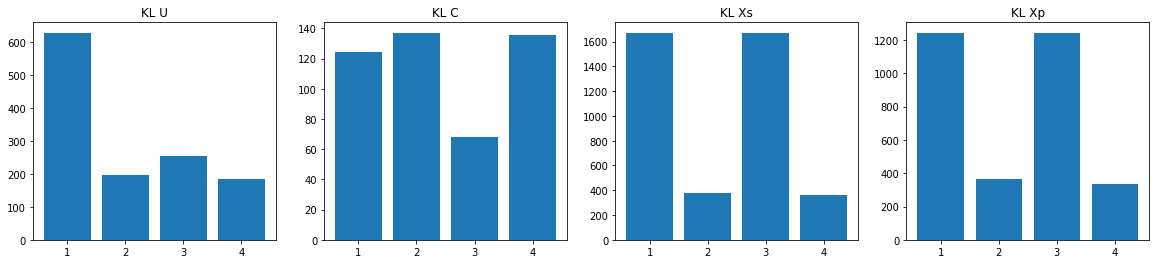

In [103]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))

axs[0].bar(np.arange(1, 5), [klu(m) for m in [m1, m2, m3, m4]])
axs[0].set_title('KL U')

axs[1].bar(np.arange(1, 5), [klc(m) for m in [m1, m2, m3, m4]])
axs[1].set_title('KL C')

axs[2].bar(np.arange(1, 5), [klxs(m) for m in [m1, m2, m3, m4]])
axs[2].set_title('KL Xs')

axs[3].bar(np.arange(1, 5), [klxp(m) for m in [m1, m2, m3, m4]])
axs[3].set_title('KL Xp')

In [104]:
def plot_var_hist(m):
    fig, axs = plt.subplots(1, 4, figsize=(18, 4))
    axs[0].hist(m.Xp_var.numpy())
    axs[0].set_title('Xp_var')
    triu_idx = np.triu_indices(m.M)
    axs[1].hist(m.q_sqrt[0].numpy()[0, triu_idx].flatten())
    axs[1].set_title('q_sqrt 0')
    axs[2].hist(m.q_sqrt[1].numpy()[0, triu_idx].flatten())
    axs[2].set_title('q_sqrt 1')
    if m.split_space:
        axs[3].hist(m.Xs_var.numpy())
        axs[3].set_title('Xs_var')

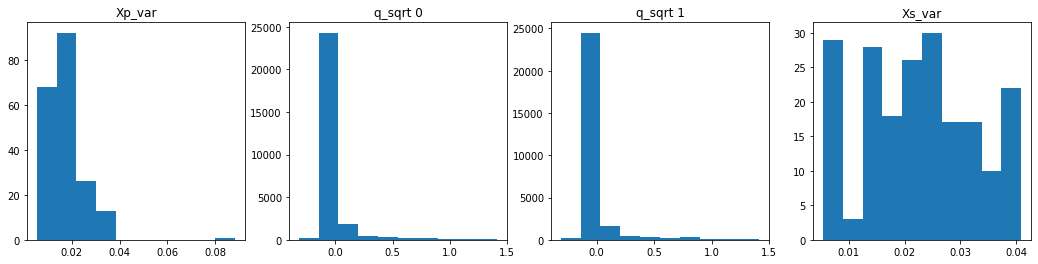

In [105]:
plot_var_hist(m2)

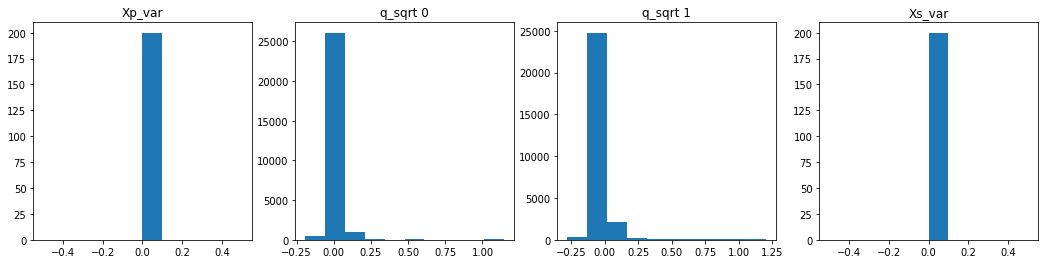

In [106]:
plot_var_hist(m3)

For comparison: GPLVM, PCA

In [82]:
gplvm = init_gplvm(
    Y=Y,
    latent_dim=2,
    kernel=gpflow.kernels.SquaredExponential(lengthscales=[1.0]*2),
    inducing_variable=Z
)
gplvm.likelihood.variance.assign(0.1)
set_trainable(gplvm.likelihood.variance, False)
set_trainable(gplvm.kernel.variance, False)
set_trainable(gplvm.kernel.lengthscales, False)
set_trainable(gplvm.inducing_variable, False)

In [83]:
gplvm

<gpflow.models.gplvm.BayesianGPLVM object at 0x1850bf748>
╒═══════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤══════════╤═════════╤═══════════════════════════════════════╕
│ name                              │ class     │ transform        │ prior   │ trainable   │ shape    │ dtype   │ value                                 │
╞═══════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪══════════╪═════════╪═══════════════════════════════════════╡
│ BayesianGPLVM.kernel.variance     │ Parameter │ Softplus         │         │ False       │ ()       │ float64 │ 1.0                                   │
├───────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼──────────┼─────────┼───────────────────────────────────────┤
│ BayesianGPLVM.kernel.lengthscales │ Parameter │ Softplus         │         │ False       │ (2,)     │ float64 │ [1. 1.]                               │
├───────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼──────────┼─────────┼───────────────────────────────────────┤
│ BayesianGPLVM.likelihood.variance │ Parameter │ Softplus + Shift │         │ False       │ ()       │ float64 │ 0.09999999999999999                   │
├───────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼──────────┼─────────┼───────────────────────────────────────┤
│ BayesianGPLVM.X_data_mean         │ Parameter │                  │         │ True        │ (200, 2) │ float64 │ [[-1.24882239, -0.26071307...         │
├───────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼──────────┼─────────┼───────────────────────────────────────┤
│ BayesianGPLVM.X_data_var          │ Parameter │ Softplus         │         │ True        │ (200, 2) │ float64 │ [[1., 1....                           │
├───────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼──────────┼─────────┼───────────────────────────────────────┤
│ BayesianGPLVM.inducing_variable.Z │ Parameter │                  │         │ False       │ (30, 2)  │ float64 │ [[-9.59595960e-01, -1.91835552e-02... │
╘═══════════════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧══════════╧═════════╧═══════════════════════════════════════╛

In [84]:
elbo_gplvm = train_scipy(gplvm, 2000, True)

step 0 elbo: -4585.539732743529
step 1 elbo: -3729.344812490752
step 2 elbo: -3465.304100373281
step 3 elbo: -3130.834575150335
step 4 elbo: -2779.744797163982
step 5 elbo: -2688.072152677143
step 6 elbo: -2549.9735359764973
step 7 elbo: -2351.885257868956
step 8 elbo: -2253.8754973056407
step 9 elbo: -2159.8322301970657
step 10 elbo: -2068.4718703132767
step 11 elbo: -1956.9742539250753
step 12 elbo: -1841.4479300627277
step 13 elbo: -1774.3138312646174
step 14 elbo: -1708.2199006835792
step 15 elbo: -1702.657537611043
step 16 elbo: -1692.604833891076
step 17 elbo: -1674.9343039751238
step 18 elbo: -1645.0402916300927
step 19 elbo: -1603.0792156414159
step 20 elbo: -1582.437874346292
step 21 elbo: -1554.1922443892
step 22 elbo: -1528.306114216086
step 23 elbo: -1506.8592897712774
step 24 elbo: -1489.2426723377373
step 25 elbo: -1476.4076444179811
step 26 elbo: -1464.2360053554835
step 27 elbo: -1452.350574899971
step 28 elbo: -1438.7794207037607
step 29 elbo: -1424.0923794208513
step 

Text(0, 0.5, 'latent dimension 2')

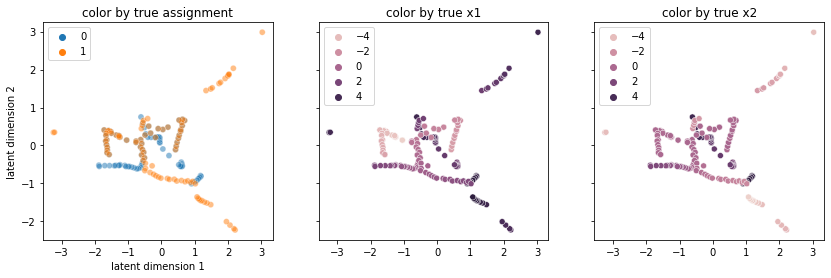

In [85]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4), sharex=True, sharey=True)
xmean = gplvm.X_data_mean.numpy()
x1 = xmean[:, 0]
x2 = xmean[:, 1]
sns.scatterplot(x=x1, y=x2, hue=labels, ax=axs[0], alpha=0.5)
axs[0].set_title('color by true assignment')
sns.scatterplot(x=x1, y=x2, hue=X[:, 0], ax=axs[1])
axs[1].set_title('color by true x1')
sns.scatterplot(x=x1, y=x2, hue=X[:, 1], ax=axs[2])
axs[2].set_title('color by true x2')
axs[0].set_xlabel('latent dimension 1')
axs[0].set_ylabel('latent dimension 2')